In [2]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *

from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num


In [3]:
use_saved = True
part_name = 's6'

In [4]:
if use_saved:
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb', create_parents=True) as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [5]:
test_size = 0.3
pca_expl_var = 0.95

## Action Recognition

In [6]:
obs_features_dict = {}

for freq_name, freq_band in FREQ_BANDS.items():
    obs_features_dict[freq_name] = participant.get_features_all_sessions_ExObs(freq_band={freq_name: freq_band})

100%|██████████| 256/256 [01:44<00:00,  2.45it/s]


In [7]:
freq_list = list(FREQ_BANDS.keys())
freq_powerset = list(chain.from_iterable(combinations(freq_list, r) for r in range(1, len(freq_list) + 1)))

In [8]:
logreg_accuracies = []
logreg_pca_accuracies = []
svm_accuracies = []
svm_pca_accuracies = []
rf_accuracies = []

y = obs_features_dict['Alpha']['label']
for subfreqs in freq_powerset:
    features = [obs_features_dict[freq_name].drop('label', axis=1) for freq_name in subfreqs]
    obs_features = pd.concat(features, axis=1)
    print(f'Using only frequencies in the band(s) {subfreqs}...')
    print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

    X_train, X_test, y_train, y_test = train_test_split(obs_features, y, test_size=test_size, random_state=RANDOM_STATE)
    logreg = LogisticRegressionModel()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_accuracies.append(accuracy)
    print(f"LogReg Accuracy: {accuracy:.2f}")
    logreg = LogisticRegressionModel(use_pca=True, expl_var=pca_expl_var)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_pca_accuracies.append(accuracy)
    print(f"LogReg PCA Accuracy: {accuracy:.2f}")
    svm = SVMModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_accuracies.append(accuracy)
    print(f"SVM Accuracy: {accuracy:.2f}")
    svm = SVMModel(use_pca=True, expl_var=pca_expl_var)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_pca_accuracies.append(accuracy)
    print(f"SVM PCA Accuracy: {accuracy:.2f}")
    svm = RandomForestModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracies.append(accuracy)
    print(f"RF Accuracy: {accuracy:.2f}")

Using only frequencies in the band(s) ('Delta',)...
The dataset contains 256 samples and 480 features.
LogReg Accuracy: 0.96
LogReg PCA Accuracy: 0.92
SVM Accuracy: 0.96
SVM PCA Accuracy: 0.94
RF Accuracy: 0.97
Using only frequencies in the band(s) ('Theta',)...
The dataset contains 256 samples and 480 features.
LogReg Accuracy: 0.88
LogReg PCA Accuracy: 0.86
SVM Accuracy: 0.90
SVM PCA Accuracy: 0.87
RF Accuracy: 0.92
Using only frequencies in the band(s) ('Alpha',)...
The dataset contains 256 samples and 480 features.
LogReg Accuracy: 0.88
LogReg PCA Accuracy: 0.87
SVM Accuracy: 0.86
SVM PCA Accuracy: 0.92
RF Accuracy: 0.84
Using only frequencies in the band(s) ('Beta',)...
The dataset contains 256 samples and 480 features.
LogReg Accuracy: 0.79
LogReg PCA Accuracy: 0.75
SVM Accuracy: 0.81
SVM PCA Accuracy: 0.82
RF Accuracy: 0.77
Using only frequencies in the band(s) ('Gamma',)...
The dataset contains 256 samples and 480 features.
LogReg Accuracy: 0.94
LogReg PCA Accuracy: 0.94
SVM Ac

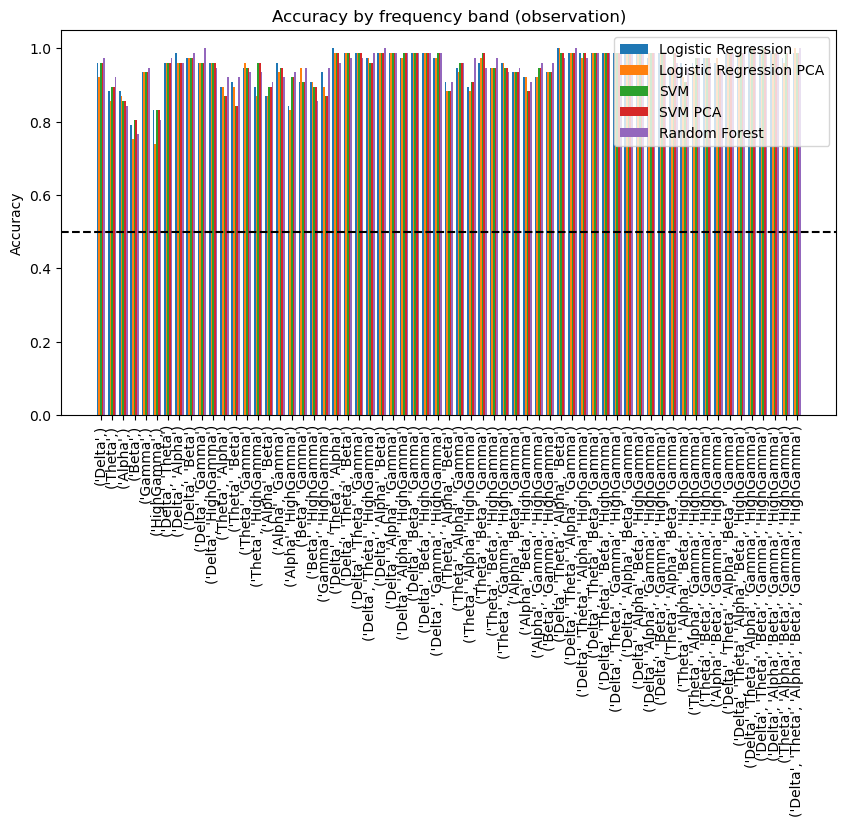

In [9]:
width = 0.15
ind = np.arange(len(freq_powerset))

plt.figure(figsize=(10,5))
plt.bar(ind, logreg_accuracies, width, label='Logistic Regression')
plt.bar(ind + width, logreg_pca_accuracies, width, label='Logistic Regression PCA')
plt.bar(ind + 2*width, svm_accuracies, width, label='SVM')
plt.bar(ind + 3*width, svm_accuracies, width, label='SVM PCA')
plt.bar(ind + 4*width, rf_accuracies, width, label='Random Forest')
plt.xticks(ind + 2*width, freq_powerset, rotation=90)
plt.axhline(0.5, linestyle='--', color='k')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy by frequency band (observation)')
plt.show()

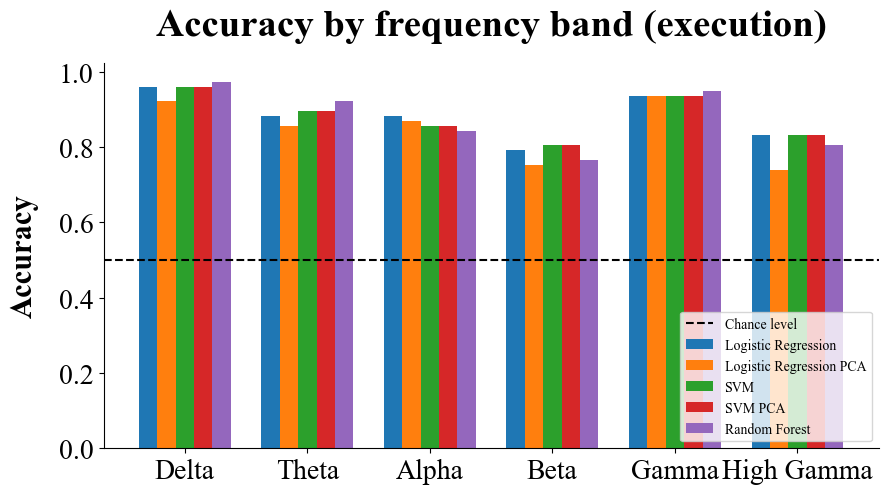

In [12]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

width = 0.15
ind = np.arange(len(freq_powerset))

plt.figure(figsize=(10,5))
plt.bar(ind[:6], logreg_accuracies[:6], width, label='Logistic Regression')
plt.bar(ind[:6] + width, logreg_pca_accuracies[:6], width, label='Logistic Regression PCA')
plt.bar(ind[:6] + 2*width, svm_accuracies[:6], width, label='SVM')
plt.bar(ind[:6] + 3*width, svm_accuracies[:6], width, label='SVM PCA')
plt.bar(ind[:6] + 4*width, rf_accuracies[:6], width, label='Random Forest')
plt.xticks(ind[:6] + 2*width, ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma'])
plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(loc='lower right', fontsize=10)
plt.ylabel('Accuracy')
plt.title('Accuracy by frequency band (execution)')
plt.show()